In [89]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [90]:
df = pd.read_csv("/content/drive/MyDrive/Data Science Eugene Pinsky/Homework_9/NVDA.csv")
df.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA
0,2017-01-03 00:00:00-05:00,2017,1,3,Tuesday,1,2017-01,26.10,26.59,24.84,25.50,150199600,25.15,0.000000,25.150000,25.150000
1,2017-01-04 00:00:00-05:00,2017,1,4,Wednesday,1,2017-01,25.85,26.38,25.38,26.10,119922000,25.74,0.023331,25.445000,25.445000
2,2017-01-05 00:00:00-05:00,2017,1,5,Thursday,1,2017-01,26.13,26.45,25.26,25.43,98429600,25.09,-0.025385,25.326667,25.326667
3,2017-01-06 00:00:00-05:00,2017,1,6,Friday,1,2017-01,25.71,26.06,25.30,25.77,82285600,25.42,0.013367,25.350000,25.350000
4,2017-01-09 00:00:00-05:00,2017,1,9,Monday,2,2017-02,25.88,27.00,25.88,26.82,91624800,26.45,0.040543,25.570000,25.570000


Getting data for each year

In [91]:
year_1_data = df[df["Year"] == 2020]
year_1_data = year_1_data.reset_index(drop=True)

year_2_data = df[df["Year"] == 2021]
year_2_data = year_2_data.reset_index(drop=True)

In [92]:
#function to carry out buy with label weekly trading strategy
def compute_profit_loss(df,end):

  #quantity of shares bought at opening price
  shares_bought = 0

  #amount gained by selling stock at adjusted closing price
  amount_gained = 0

  price_x = 0

  #string variable to determine current position (default value in cash / or not in market)
  position = "in cash"

  #iterating through dataframe
  for index,row in df.iterrows():

    #if we are in the first record skip it.
    if index == 0:
      continue

    #if next week's predicted closing is equal to this week's adjusted closing - do nothing.
    if df["Adj Close"][index-1] == df["Linear_model_pred"][index]:
      continue

    #if next week's predicted closing is greater to this week's adjusted closing - assume price will rise
    elif df["Adj Close"][index-1] < df["Linear_model_pred"][index]:

      #a)if we are not invested in market
      if position == "in cash":
        
        #buying 100 dollars worth of stock
        shares_bought = 100/df["Adj Close"][index-1]

        #changing position to long
        position = "long"

        price_x = df["Adj Close"][index-1]

      #b)if we already in long position 
      elif position == "long":

        position = "long"

      #c)if we are in a short position
      elif position == "short":
        
        position = "in cash"

        profit_loss = price_x - df["Adj Close"][index-1]

        df["Profit/Loss per trade"][index-1] = profit_loss


    #if next week's predicted closing is less than this week's adjusted closing - assume price will drop
    elif df["Adj Close"][index-1] > df["Linear_model_pred"][index]:

      #a)if we are not invested in market
      if position == "in cash":
        
        position = "short"

        shares_bought = 100/df["Adj Close"][index-1]

        price_x = df["Adj Close"][index-1]

      #b)if we already in short position 
      elif position == "short":

        position = "short"


      #c)if we are in a long position
      elif position == "long":

        #closing the position
        position = "in cash"

        profit_loss = df["Adj Close"][index-1] - price_x

        df["Profit/Loss per trade"][index-1] = profit_loss

  return df["Profit/Loss per trade"].mean()

In [93]:
#df to store average profit/loss per trade for each window size against different models
results_df = pd.DataFrame(columns=["W","Average Profit/Loss per trade"]) 

#getting different values for W or window.
for window in range(5,31):

  year_1_data["Linear_model_pred"] = 0

  for i,j in enumerate(range(window+1,len(year_1_data))):

    #getting previous W (window) values to train polynomial functions
    lin_coef = np.polyfit(year_1_data["Day"].iloc[i:i+window],year_1_data["Adj Close"].iloc[i:i+window],1)

    #storing predicted values in column for predicted values of each polynomial function.
    year_1_data["Linear_model_pred"][j] = np.polyval(lin_coef,year_1_data["Day"][j])

  year_1_data_temp = year_1_data.iloc[i:i+window+1]
  year_1_data_temp = year_1_data_temp.reset_index(drop=True)

  year_1_data_temp["Profit/Loss per trade"] = 0
  year_1_data_temp = year_1_data_temp[["Day","Open","Adj Close","Linear_model_pred","Profit/Loss per trade"]]

  profit_loss= compute_profit_loss(year_1_data_temp,len(year_1_data)-1)

  results_df = results_df.append({"W":window,"Average Profit/Loss per trade":profit_loss},ignore_index=True)

In [94]:
results_df

,W,Average Profit/Loss per trade
0,5.0,0.333333
1,6.0,-0.142857
2,7.0,-0.375000
3,8.0,-0.333333
4,9.0,-0.300000
5,10.0,0.000000
6,11.0,0.166667
7,12.0,0.384615
8,13.0,0.428571
9,14.0,0.400000


Text(0, 0.5, 'Averege Profit/Loss ')

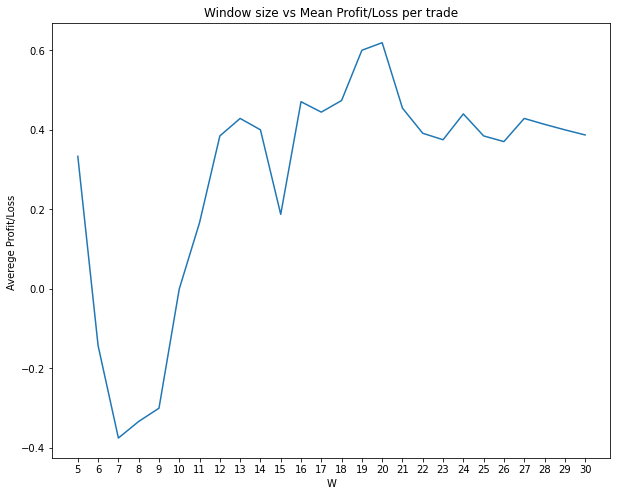

In [95]:
fig = plt.figure(figsize=(10,8))
plt.plot(results_df["W"],results_df["Average Profit/Loss per trade"])
plt.xticks(results_df["W"])
plt.title("Window size vs Mean Profit/Loss per trade")
plt.xlabel("W")
plt.ylabel("Averege Profit/Loss ")

## Q2.

In [96]:
year_2_data

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA
0,2021-01-04 00:00:00-05:00,2021,1,4,Monday,1,2021-01,131.04,136.52,129.62,131.13,56064000,130.93,0.004481,131.436429,132.4336
1,2021-01-05 00:00:00-05:00,2021,1,5,Tuesday,1,2021-01,131.00,134.43,130.87,134.05,32276000,133.84,0.022210,131.505000,132.4432
2,2021-01-06 00:00:00-05:00,2021,1,6,Wednesday,1,2021-01,132.23,132.45,125.86,126.14,58042400,125.95,-0.058953,130.972857,132.2492
3,2021-01-07 00:00:00-05:00,2021,1,7,Thursday,1,2021-01,129.68,133.78,128.87,133.44,46148000,133.23,0.057830,131.045000,132.2904
4,2021-01-08 00:00:00-05:00,2021,1,8,Friday,1,2021-01,133.62,134.21,130.42,132.77,29252800,132.56,-0.005040,130.998571,132.2672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2021-12-23 00:00:00-05:00,2021,12,23,Thursday,51,2021-51,297.55,300.59,294.31,296.40,34302200,296.20,0.008163,295.482857,284.7548
247,2021-12-27 00:00:00-05:00,2021,12,27,Monday,52,2021-52,296.60,310.87,296.40,309.45,40368600,309.24,0.044029,296.130714,286.5938
248,2021-12-28 00:00:00-05:00,2021,12,28,Tuesday,52,2021-52,313.12,313.30,300.12,303.22,42059100,303.01,-0.020133,294.627857,288.2852
249,2021-12-29 00:00:00-05:00,2021,12,29,Wednesday,52,2021-52,302.73,305.48,293.66,300.01,34313900,299.81,-0.010586,293.325714,289.8406


In [97]:
window = 20 

year_2_data["Linear_model_pred"] = 0

for i,j in enumerate(range(window+1,len(year_2_data))):

  #getting previous W (window) values to train polynomial functions
  lin_coef = np.polyfit(year_2_data["Day"].iloc[i:i+window],year_2_data["Adj Close"].iloc[i:i+window],1)

  #storing predicted values in column for predicted values of each polynomial function.
  year_2_data["Linear_model_pred"][j] = np.polyval(lin_coef,year_2_data["Day"][j])


In [98]:
#taking relevant data
year_2_data = year_2_data.iloc[21:]
year_2_data = year_2_data.reset_index(drop=True)
year_2_data.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA,Linear_model_pred
0,2021-02-03 00:00:00-05:00,2021,2,3,Wednesday,5,2021-05,136.36,139.32,135.16,135.30,24540800,135.10,-0.001936,132.938571,132.3528,132
1,2021-02-04 00:00:00-05:00,2021,2,4,Thursday,5,2021-05,135.31,136.74,133.38,136.64,20134000,136.43,0.009885,133.269286,132.4686,132
2,2021-02-05 00:00:00-05:00,2021,2,5,Friday,5,2021-05,137.25,137.37,135.46,135.91,16915200,135.70,-0.005361,133.790714,132.5594,133
3,2021-02-08 00:00:00-05:00,2021,2,8,Monday,6,2021-06,137.27,144.74,137.27,144.39,43462400,144.16,0.062376,134.798571,132.8558,134
4,2021-02-09 00:00:00-05:00,2021,2,9,Tuesday,6,2021-06,143.41,145.83,142.23,142.63,28756000,142.41,-0.012155,135.438571,133.0620,134


In [99]:
#computing r2 score for year 2
year_2_data["r2_score"] = 0

for i,j in enumerate(range(window+1,len(year_2_data))):

  #taking previous W predictions and computing r2 score
  year_2_data["r2_score"][j] = r2_score(year_2_data["Adj Close"].iloc[i:i+window],year_2_data["Linear_model_pred"].iloc[i:i+window])


Text(0, 0.5, 'R2 score ')

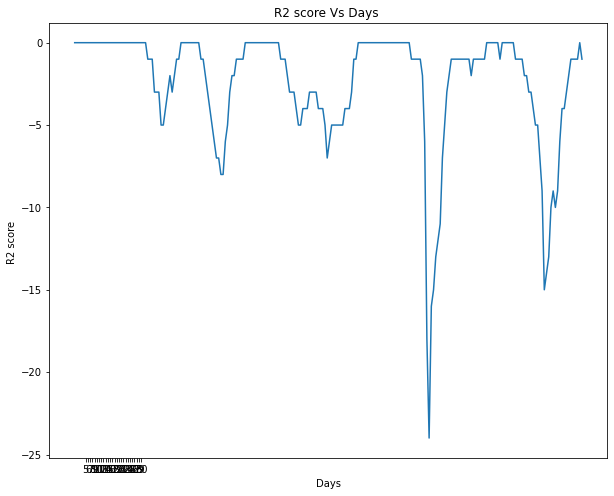

In [100]:
fig = plt.figure(figsize=(10,8))
plt.plot(year_2_data.index,year_2_data["r2_score"])
plt.xticks(results_df["W"])
plt.title("R2 score Vs Days ")
plt.xlabel("Days")
plt.ylabel("R2 score ")

In [101]:
print("The average R2 score is : "+ str(round(year_2_data["r2_score"].mean()/10,2)))

The average R2 score is : -0.24


## Q3.

In [102]:
#function to carry out buy with label weekly trading strategy
def compute_long_short(df,end):

  #count of long positions
  long_position = 0 

  #count of short positions
  short_position = 0

  #quantity of shares bought at opening price
  shares_bought = 0

  #amount gained by selling stock at adjusted closing price
  amount_gained = 0

  price_x = 0

  #string variable to determine current position (default value in cash / or not in market)
  position = "in cash"

  #iterating through dataframe
  for index,row in df.iterrows():

    #if we are in the first record skip it.
    if index == 0:
      continue

    #if next week's predicted closing is equal to this week's adjusted closing - do nothing.
    if df["Adj Close"][index-1] == df["Linear_model_pred"][index]:
      continue

    #if next week's predicted closing is greater to this week's adjusted closing - assume price will rise
    elif df["Adj Close"][index-1] < df["Linear_model_pred"][index]:

      #a)if we are not invested in market
      if position == "in cash":
        
        #buying 100 dollars worth of stock
        shares_bought = 100/df["Adj Close"][index-1]

        #changing position to long
        position = "long"

        long_position = long_position + 1 

        price_x = df["Adj Close"][index-1]

      #b)if we already in long position 
      elif position == "long":

        position = "long"

      #c)if we are in a short position
      elif position == "short":
        
        position = "in cash"

        profit_loss = price_x - df["Adj Close"][index-1]

        #df["Profit/Loss per trade"][index-1] = profit_loss


    #if next week's predicted closing is less than this week's adjusted closing - assume price will drop
    elif df["Adj Close"][index-1] > df["Linear_model_pred"][index]:

      #a)if we are not invested in market
      if position == "in cash":
        
        position = "short"

        short_position = short_position + 1 

        shares_bought = 100/df["Adj Close"][index-1]

        price_x = df["Adj Close"][index-1]

      #b)if we already in short position 
      elif position == "short":

        position = "short"


      #c)if we are in a long position
      elif position == "long":

        #closing the position
        position = "in cash"

        profit_loss = df["Adj Close"][index-1] - price_x

        #df["Profit/Loss per trade"][index-1] = profit_loss

  return long_position,short_position

In [103]:
window = 20 

year_2_data["Linear_model_pred"] = 0

for i,j in enumerate(range(window+1,len(year_2_data))):

  #getting previous W (window) values to train polynomial functions
  lin_coef = np.polyfit(year_2_data["Day"].iloc[i:i+window],year_2_data["Adj Close"].iloc[i:i+window],1)

  #storing predicted values in column for predicted values of each polynomial function.
  year_2_data["Linear_model_pred"][j] = np.polyval(lin_coef,year_2_data["Day"][j])

long_position,short_position = compute_long_short(year_2_data,len(year_2_data)-1)

In [104]:
print("The number of long positions are: "+ str(long_position))
print("The number of short positions are: "+ str(short_position))

The number of long positions are: 10
The number of short positions are: 11


## Q4.

In [105]:
def compute_trade_by_position(df,end):

  #count of long positions
  long_position = 0 

  #count of short positions
  short_position = 0

  #quantity of shares bought at opening price
  shares_bought = 0

  #amount gained by selling stock at adjusted closing price
  amount_gained = 0

  price_x = 0

  #string variable to determine current position (default value in cash / or not in market)
  position = "in cash"

  #iterating through dataframe
  for index,row in df.iterrows():

    #if we are in the first record skip it.
    if index == 0:
      continue

    #if next week's predicted closing is equal to this week's adjusted closing - do nothing.
    if df["Adj Close"][index-1] == df["Linear_model_pred"][index]:
      continue

    #if next week's predicted closing is greater to this week's adjusted closing - assume price will rise
    elif df["Adj Close"][index-1] < df["Linear_model_pred"][index]:

      #a)if we are not invested in market
      if position == "in cash":
        
        #buying 100 dollars worth of stock
        shares_bought = 100/df["Adj Close"][index-1]

        #changing position to long
        position = "long"

        long_position = long_position + 1 

        price_x = df["Adj Close"][index-1]

      #b)if we already in long position 
      elif position == "long":

        position = "long"

      #c)if we are in a short position
      elif position == "short":
        
        position = "in cash"

        profit_loss = price_x - df["Adj Close"][index-1]

        df["Profit/Loss per short trade"][index-1] = profit_loss


    #if next week's predicted closing is less than this week's adjusted closing - assume price will drop
    elif df["Adj Close"][index-1] > df["Linear_model_pred"][index]:

      #a)if we are not invested in market
      if position == "in cash":
        
        position = "short"

        short_position = short_position + 1 

        shares_bought = 100/df["Adj Close"][index-1]

        price_x = df["Adj Close"][index-1]

      #b)if we already in short position 
      elif position == "short":

        position = "short"


      #c)if we are in a long position
      elif position == "long":

        #closing the position
        position = "in cash"

        profit_loss = df["Adj Close"][index-1] - price_x

        df["Profit/Loss per long trade"][index-1] = profit_loss

  return df

In [106]:
window = 20 

year_2_data["Linear_model_pred"] = 0
year_2_data["Profit/Loss per long trade"] = 0
year_2_data["Profit/Loss per short trade"] = 0 


for i,j in enumerate(range(window+1,len(year_2_data))):

  #getting previous W (window) values to train polynomial functions
  lin_coef = np.polyfit(year_2_data["Day"].iloc[i:i+window],year_2_data["Adj Close"].iloc[i:i+window],1)

  #storing predicted values in column for predicted values of each polynomial function.
  year_2_data["Linear_model_pred"][j] = np.polyval(lin_coef,year_2_data["Day"][j])

year_2_data = compute_trade_by_position(year_2_data,len(year_2_data)-1)

In [107]:
print("The average profit or loss per long position trade is: " + str(round(year_2_data["Profit/Loss per long trade"].mean(),2)))
print("The average profit or loss per short position trade is: " + str(round(year_2_data["Profit/Loss per short trade"].mean(),2)))

The average profit or loss per long position trade is: 0.31
The average profit or loss per short position trade is: -0.35


## Q5.

In [108]:
print("The average number of long positions are: "+ str(round(long_position/year_2_data.shape[0],2)))
print("The average number of short positions are: "+ str(round(short_position/year_2_data.shape[0],2)))

The average number of long positions are: 0.04
The average number of short positions are: 0.05


## Q6.

In [109]:
def compute_long_short(df,end):

  #count of long positions
  long_position = 0 

  #count of short positions
  short_position = 0

  #quantity of shares bought at opening price
  shares_bought = 0

  #amount gained by selling stock at adjusted closing price
  amount_gained = 0

  price_x = 0

  #string variable to determine current position (default value in cash / or not in market)
  position = "in cash"

  #iterating through dataframe
  for index,row in df.iterrows():

    #if we are in the first record skip it.
    if index == 0:
      continue

    #if next week's predicted closing is equal to this week's adjusted closing - do nothing.
    if df["Adj Close"][index-1] == df["Linear_model_pred"][index]:
      continue

    #if next week's predicted closing is greater to this week's adjusted closing - assume price will rise
    elif df["Adj Close"][index-1] < df["Linear_model_pred"][index]:

      #a)if we are not invested in market
      if position == "in cash":
        
        #buying 100 dollars worth of stock
        shares_bought = 100/df["Adj Close"][index-1]

        #changing position to long
        position = "long"

        long_position = long_position + 1 

        price_x = df["Adj Close"][index-1]

      #b)if we already in long position 
      elif position == "long":

        position = "long"

      #c)if we are in a short position
      elif position == "short":
        
        position = "in cash"

        profit_loss = price_x - df["Adj Close"][index-1]

        #df["Profit/Loss per trade"][index-1] = profit_loss


    #if next week's predicted closing is less than this week's adjusted closing - assume price will drop
    elif df["Adj Close"][index-1] > df["Linear_model_pred"][index]:

      #a)if we are not invested in market
      if position == "in cash":
        
        position = "short"

        short_position = short_position + 1 

        shares_bought = 100/df["Adj Close"][index-1]

        price_x = df["Adj Close"][index-1]

      #b)if we already in short position 
      elif position == "short":

        position = "short"


      #c)if we are in a long position
      elif position == "long":

        #closing the position
        position = "in cash"

        profit_loss = df["Adj Close"][index-1] - price_x

        #df["Profit/Loss per trade"][index-1] = profit_loss

  return long_position,short_position

window = 20 

year_1_data["Linear_model_pred"] = 0

for i,j in enumerate(range(window+1,len(year_1_data))):

  #getting previous W (window) values to train polynomial functions
  lin_coef = np.polyfit(year_1_data["Day"].iloc[i:i+window],year_1_data["Adj Close"].iloc[i:i+window],1)

  #storing predicted values in column for predicted values of each polynomial function.
  year_1_data["Linear_model_pred"][j] = np.polyval(lin_coef,year_1_data["Day"][j])

long_position,short_position = compute_long_short(year_1_data,len(year_1_data)-1)

print("The number of long positions are: "+ str(long_position))
print("The number of short positions are: "+ str(short_position))

The number of long positions are: 12
The number of short positions are: 17


In [110]:
def compute_trade_by_position(df,end):

  #count of long positions
  long_position = 0 

  #count of short positions
  short_position = 0

  #quantity of shares bought at opening price
  shares_bought = 0

  #amount gained by selling stock at adjusted closing price
  amount_gained = 0

  price_x = 0

  #string variable to determine current position (default value in cash / or not in market)
  position = "in cash"

  #iterating through dataframe
  for index,row in df.iterrows():

    #if we are in the first record skip it.
    if index == 0:
      continue

    #if next week's predicted closing is equal to this week's adjusted closing - do nothing.
    if df["Adj Close"][index-1] == df["Linear_model_pred"][index]:
      continue

    #if next week's predicted closing is greater to this week's adjusted closing - assume price will rise
    elif df["Adj Close"][index-1] < df["Linear_model_pred"][index]:

      #a)if we are not invested in market
      if position == "in cash":
        
        #buying 100 dollars worth of stock
        shares_bought = 100/df["Adj Close"][index-1]

        #changing position to long
        position = "long"

        long_position = long_position + 1 

        price_x = df["Adj Close"][index-1]

      #b)if we already in long position 
      elif position == "long":

        position = "long"

      #c)if we are in a short position
      elif position == "short":
        
        position = "in cash"

        profit_loss = price_x - df["Adj Close"][index-1]

        df["Profit/Loss per short trade"][index-1] = profit_loss


    #if next week's predicted closing is less than this week's adjusted closing - assume price will drop
    elif df["Adj Close"][index-1] > df["Linear_model_pred"][index]:

      #a)if we are not invested in market
      if position == "in cash":
        
        position = "short"

        short_position = short_position + 1 

        shares_bought = 100/df["Adj Close"][index-1]

        price_x = df["Adj Close"][index-1]

      #b)if we already in short position 
      elif position == "short":

        position = "short"


      #c)if we are in a long position
      elif position == "long":

        #closing the position
        position = "in cash"

        profit_loss = df["Adj Close"][index-1] - price_x

        df["Profit/Loss per long trade"][index-1] = profit_loss

  return df

window = 20 

year_1_data["Linear_model_pred"] = 0
year_1_data["Profit/Loss per long trade"] = 0
year_1_data["Profit/Loss per short trade"] = 0 


for i,j in enumerate(range(window+1,len(year_1_data))):

  #getting previous W (window) values to train polynomial functions
  lin_coef = np.polyfit(year_1_data["Day"].iloc[i:i+window],year_1_data["Adj Close"].iloc[i:i+window],1)

  #storing predicted values in column for predicted values of each polynomial function.
  year_1_data["Linear_model_pred"][j] = np.polyval(lin_coef,year_1_data["Day"][j])

year_1_data = compute_trade_by_position(year_1_data,len(year_1_data)-1)

print("The average profit or loss per long position trade is: " + str(round(year_1_data["Profit/Loss per long trade"].mean(),2)))
print("The average profit or loss per short position trade is: " + str(round(year_1_data["Profit/Loss per short trade"].mean(),2)))

The average profit or loss per long position trade is: 0.11
The average profit or loss per short position trade is: -0.04


In [111]:
print("The average number of long positions are: "+ str(round(long_position/year_1_data.shape[0],2)))
print("The average number of short positions are: "+ str(round(short_position/year_1_data.shape[0],2)))

The average number of long positions are: 0.05
The average number of short positions are: 0.07
